# Policy Gradient --- Practical Session (Solution)

In [1]:
import gym
import jax
import jax.numpy as jnp
import jax.random as random
from jax import grad
jax.config.update('jax_platform_name', 'cpu')

## Setting up the RL task with Openai Gym

Gym (https://www.gymlibrary.ml/) is the de facto standard interface for simulating **Markov Decision Processes** (MDPs).

An MDP is made of 
* a **state space** $\mathcal{S}$
* an **action space** $\mathcal{A}$
* a **starting-state distribution** $\mu(s)$
* a **transition function** $p(s'\mid s,a)$
* a **reward function** $r(s,a)$

![title](img/rl.png)

Let's start by creating an MDP (our **environment** or reinforcement learning **task**).

Gym has several ready-to-use tasks (you can also create custom environments by implementing the gym interface)

The `make` method accepts a string that specifies the name and version of the task. 

In [2]:
env = gym.make("CartPole-v1")

**Cart-Pole** is a standard control task where the goal is to balance a pole that is attached to a cart, only by controlling the horizontal motion of the cart.

![title](img/cartpole.gif)

Let's have a look at the **state space**:

In [3]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In this MDP, a state is a vector of 4 real numbers (cart position, cart velocity, pole angle, pole angular velocity). We call this a *continuous* state space.

Let's take note of the state dimension:

In [4]:
state_dim = env.observation_space.shape[0]

Now let's have a look at the **action space**:

In [5]:
env.action_space

Discrete(2)

We only have two actions, `0` (push cart to the left) and `1` (push cart to the right). This is a *finite* action space. 

Let's take note of the number of actions:

In [6]:
n_actions = env.action_space.n

The **starting-state distribution** is given by the `reset` method. It returns the initial state, which is a random vector not too far from zero, corresponding to the cart being almost in the center, the pole being almost vertical, and both almost still.

In [7]:
env.reset()

array([ 0.00603669, -0.02030374,  0.04423506, -0.00095   ], dtype=float32)

Both the **transition function** and the **reward function** are implemented by the `step` method. It takes an action and it returns the next state, the reward, a termination or "done" flag and a side-information dictionary (the latter is empty for Cart-Pole)

In [8]:
env.step(0)

(array([ 0.00563061, -0.21603125,  0.04421606,  0.30535495], dtype=float32),
 1.0,
 False,
 {})

Note that the environment object is *stateful*: the next state and reward depend on the (internal) current state and the given action.

In Cartpole, reward is 1 at every step (if the pole is up, you are doing good)

The episode terminates (`step` returns a `True` done flag) when the pole falls outside a certain angle or the cart goes too far to the left or to the right.

See the docs for more detailed info on the Cart-Pole task (https://www.gymlibrary.ml/environments/classic_control/cart_pole/)

## A simple agent interface

We have our environment, now let's build an **agent**. 

Our agent will `act` depending on the current state and `update` its behavior based on experience (learn).

Our default implementation is an agent that does random actions and does not learn anything. This agent has a fixed **stochastic policy**

$\LARGE\mathbb{P}(A_t=a\mid S_t=s) = \pi(a\mid s)$

In [9]:
class Agent:
    """
    A (learning) agent
    
    Attributes
    seed: random seed (for reproducibility)
    """
    
    def __init__(self, seed=0):
        self.reset(seed=seed)
    
    def reset(self, seed=0):
        """
        Reset policy to default and re-seed the random number generator
        
        Parameters
        seed: random seed (for reproducibility)
        """
        self.key = random.PRNGKey(seed) #jax RNG bookkeeping (not important)
    
    def act(self, state):
        """
        The current policy of the agent.
        
        Parameters
        state: the current state of the MDP
        
        Returns: the selected action
        """
        self.key, subkey = random.split(self.key) #jax RNG bookkeeping (not important)
        action_probs = jnp.ones(n_actions) / n_actions
        action = random.choice(subkey, n_actions, p=action_probs).item() # sample (random) action
        return action
    
    def update(self, state, action, discounted_reward, next_state, done):
        """
        Update the agent's policy given one piece of interaction data
        
        Parameters
        state: last state in which an action was selected
        action: last action selected by the agent
        discounted_reward: last reward received by the agent, already discounted
        next_state: state resulting from the agent's last action
        done: True if next_state is a terminal state
        
        Returns: None
        """
        pass

## The interaction loop

The following function makes the agent interact with the environment over several episodes and records the **performance** of the agent at each episode

$\LARGE J(\pi)=\mathbb{E}_{S_0\sim\mu, A_t\sim\pi(\cdot|S_t),S_{t+1}\sim p(\cdot|S_t,A_t)}\left[\sum_{t=0}^\infty\gamma^t R_{t+1}\right]$

We can use *random seeds* to make the experiment fully reproducible. 

The code for randomization is already here. If you want to know more about random numbers in Jax see https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#jax-prng

In [10]:
def run_interaction(env, agent, n_steps=10**5, discount=0.99, seed=None, render=False):
    """
    Simulates several episodes of interaction between an MDP and an (learning) agent
    
    Parameters
    env: the MDP
    agent: the agent
    n_steps: total number of interaction time-steps (may result in multiple episodes)
    seed: random seed
    render: if True, the interaction is displayed graphically
    
    Returns: a list with the agent's performance for each episode
    """    
    performance = 0.
    performances = [] #we will store the performance of each episode
    state = env.reset(seed=seed) #sample initial state
    last_reset = 0 #starting timestep of the current episode
    episode = 1 #index of current episode
    
    for t in range(n_steps): #interaction loop
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        discounted_reward = reward * discount**(t - last_reset) #discounting is from the start of the episode
        performance += discounted_reward
        
        #Display interaction
        if render:
            env.render()
            
        #Update the agent's policy with the latest piece of interaction data
        agent.update(state, action, discounted_reward, next_state, done)
        
        if done: #go to next episode
            print('Episode %d: performance = %.2f' % (episode, performance))
            episode += 1
            performances.append(performance)
            performance = 0
            state = env.reset()
            last_reset = t + 1
        else: #go to next state
            state = next_state
        
    env.close()
    return performances

Let's simulate the interaction of the random agent with the cartpole environment

In [11]:
random_agent = Agent(seed=0)
performances = run_interaction(env, random_agent, n_steps=1000, render=False, seed=0)

Episode 1: performance = 14.85
Episode 2: performance = 12.25
Episode 3: performance = 9.56
Episode 4: performance = 17.38
Episode 5: performance = 12.25
Episode 6: performance = 11.36
Episode 7: performance = 11.36
Episode 8: performance = 18.21
Episode 9: performance = 19.03
Episode 10: performance = 15.71
Episode 11: performance = 17.38
Episode 12: performance = 33.77
Episode 13: performance = 25.28
Episode 14: performance = 15.71
Episode 15: performance = 43.04
Episode 16: performance = 28.94
Episode 17: performance = 30.36
Episode 18: performance = 20.64
Episode 19: performance = 15.71
Episode 20: performance = 28.23
Episode 21: performance = 11.36
Episode 22: performance = 11.36
Episode 23: performance = 14.85
Episode 24: performance = 31.74
Episode 25: performance = 15.71
Episode 26: performance = 8.65
Episode 27: performance = 11.36
Episode 28: performance = 26.03
Episode 29: performance = 23.00
Episode 30: performance = 9.56
Episode 31: performance = 10.47
Episode 32: performa

Let's plot the performance over the episodes. This is called a **learning curve**, but this agent cannot learn anything

Text(0, 0.5, 'Performance')

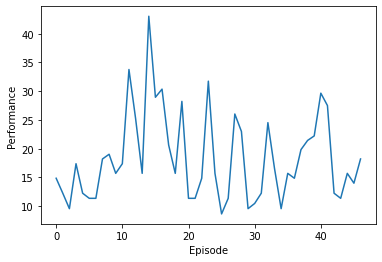

In [12]:
import matplotlib.pyplot as plt #matlab-like plots https://matplotlib.org/stable/tutorials/introductory/pyplot.html

plt.plot(performances)
plt.xlabel("Episode")
plt.ylabel("Performance")

## Policy Gradient: theory recap

We fix a parametric policy class

$\LARGE \Pi=\{\pi_\theta\mid\theta\in\Theta\}$

We use the following shorthand for the performance measure:

$\LARGE J(\theta) = J(\pi_\theta)$

And learn policy parameters by **gradient ascent**

$\LARGE \theta\gets\theta+\alpha\nabla_\theta J(\theta)$

where $\alpha$ is the **learning rate** and the expression of the gradient is given by the **policy gradient theorem**

$\Large\nabla_\theta J(\theta) = (1-\gamma)^{-1}\mathbb{E}_{S\sim d_\theta, A\sim\pi_\theta(\cdot| S)}\left[\nabla_\theta\log\pi_\theta(A| S)Q^\theta(S,A)\right]$

where the state-action value function is:

$\LARGE Q^\theta(s,a) = \mathbb{E}_\theta\left[\sum_{t=0}^\infty\gamma^t R_{t+1}\bigg|S_0=s, A_0=a\right]$

and the discounted state-occupancy measure is:

$\LARGE d_\theta(s)=(1-\gamma)\sum_{t=0}^\infty\gamma^t\mathbb{P}_\theta(S_t=s)$

## JAX quickstart

JAX is a numerical computing and automatic differentiation library.

The basic objects are (multi-dimensional) arrays (same as in *numpy*)

In [13]:
import jax.numpy as jnp #same as numpy!

v = jnp.array([0.3, 0.2, 0.5]) #a 1-D array (a vector)
A = jnp.array([[1.,-1.,0],[0,1.,1.]]) # a 2-D array (a matrix)

We can access arrays for reading values

In [14]:
v[1] #second element of the vector

DeviceArray(0.2, dtype=float32)

In [15]:
A[0,1] #matrix element in first row and second column

DeviceArray(-1., dtype=float32)

For advanced array reading, see slicing in numpy https://www.w3schools.com/python/numpy/numpy_array_slicing.asp.

For example we can reverse an array as follows:

In [16]:
v[::-1]

DeviceArray([0.5, 0.2, 0.3], dtype=float32)

**Important**: jax arrays are *immutable*:

In [17]:
try:
    v[1] = 0. #attempt to assign new value to array element
except Exception as e:
    print(e)

'<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


You must create a new array instead

In [18]:
w = v.at[1].set(0.)
w

DeviceArray([0.3, 0. , 0.5], dtype=float32)

We can perform linear algebra on arrays

In [19]:
#Elementwise operations (the result is always a new array)
print(v+v)
print(2*v)
print(v*v)

[0.6 0.4 1. ]
[0.6 0.4 1. ]
[0.09 0.04 0.25]


In [20]:
A @ v #matrix multiplication

DeviceArray([0.10000001, 0.7       ], dtype=float32)

In [21]:
jnp.dot(v,v) #dot product

DeviceArray(0.38, dtype=float32)

In [22]:
A.T #matrix transpose

DeviceArray([[ 1.,  0.],
             [-1.,  1.],
             [ 0.,  1.]], dtype=float32)

We can easily **differentiate** functions with `grad`

In [23]:
from jax import grad

def f(x):
    return jnp.dot(x, x)

nabla_f = grad(f) #gradient of f w.r.t. x (itself a function)

In [24]:
nabla_f(v) #the gradient of f evaluated at x=v (the gradient of x^Tx is 2x)

DeviceArray([0.6, 0.4, 1. ], dtype=float32)

Finally, some useful jax functions (you may need them for the exercises)

* `jnp.dot` : dot product https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.dot.html
* `jnp.log` : natural logarithm https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.log.html
* `jnp.exp` : exponential https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.exp.html
* `jnp.sum` : sum of array elements https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.sum.html
* `jnp.cumsum` : cumulative sum https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.cumsum.html

## EXERCISE 1: Softmax policy

It's your turn to implement an agent that acts according to a parametric policy

The **Softmax policy** is often used for finite actions. A possible formulation is:

$\Huge \pi_\theta(a\mid s) = \frac{\exp(\theta_a\cdot s)}{\sum_{a'\in\mathcal{A}}\exp(\theta_{a'}\cdot s)}$

where the policy parameter $\theta$ is a 2-D array (matrix) of size n_actions $\times$ state_dim and $\theta_a$ denotes the row of $\theta$ corresponding to action $a$. 

This is called a *linear* softmax policy because, for each action, the (unnormalized) log-probability is given by a linear combination of $\theta_a$ and the current state.

To implement the softmax policy, you just need to implement the `policy` method in the code below, which returns the probability of playing each action given the policy parameters and the state.

*Suggestion: implement the log-action probabilities first in the* `log_policy` *method*

Note that, even if the SoftmaxAgent object stores the current policy parameters as `self.policy_parameters`, the `policy` and `log_policy` methods take parameters as an input. This is to allow differentiation with JAX in the following steps. 

### A note on numerical issues
When $\theta_a\cdot s$ is a large positive number, $\exp(\theta_a\cdot s)$ may be huge and overflow!
To prevent this we can subtract a constant $C$ from all the logits. Thanks to the normalization, the result does not change!

$\Large\frac{\exp(\theta_a\cdot s \:-\: C)}{\sum_{a'\in\mathcal{A}}\exp(\theta_{a'}\cdot s \:-\: C)} = \frac{\exp(\theta_a\cdot s)e^{-C}}{\sum_{a'\in\mathcal{A}}\exp(\theta_{a'}\cdot s)e^{-C}} = \frac{\exp(\theta_a\cdot s)}{\sum_{a'\in\mathcal{A}}\exp(\theta_{a'}\cdot s)}$

An obvious choice for the constant offset is $C = \max_{a}\{\theta_a\cdot s\}$ (it can depend on the state, just not on the action). Since now $C$ depends on $\theta$, we should make sure this term is ignored when computing policy gradients.

In [25]:
class SoftmaxAgent(Agent):
    """
    Agent implementing a fixed linear-Softmax policy.
    
    Attributes
    state_dim: dimension of state vector
    n_actions: number of available actions
    """
    def __init__(self, state_dim, n_actions, seed=0):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.reset(seed=seed)
        
    def reset(self, seed=0):
        """Set policy parameters to all zeros and re-seed random number generator"""
        self.key = random.PRNGKey(seed)
        self.policy_parameters = jnp.zeros((self.n_actions, self.state_dim))
    
    def log_policy(self, policy_parameters, state):
        """
        Logarithm of action probability given policy parameters and state
        
        Parameters
        policy_parameters: parameters (theta) of the policy to evaluate
        state: the current state
        
        Returns
        a vector of log-probabilities, one for each action
        """
        state_features = jnp.array(state) #let's make sure the state is a jax array
        
        #SOLUTION
        weights = jnp.dot(policy_parameters, state_features)
        offset = jax.lax.stop_gradient(jnp.max(weights)) #let's make sure we do not differentiate wrt the offset
        weights = weights - offset
        log_sum_exp = jnp.log(jnp.sum(jnp.exp(weights)))
        return weights - log_sum_exp
        #END SOLUTION
    
    def policy(self, policy_parameters, state):
        """
        Action probability given policy parameters and state
        
        Parameters
        policy_parameters: parameters (theta) of the policy to evaluate
        state: the current state
        
        Returns
        a vector of probabilities, one for each action
        """
        #SOLUTION
        return jnp.exp(self.log_policy(policy_parameters, state))
        #END SOLUTION
    
    def act(self, state):
        self.key, subkey = random.split(self.key)
        action_probs = self.policy(self.policy_parameters, state)
        action = random.choice(subkey, n_actions, p=action_probs).item()
        return action
    
    def score_function(self, policy_parameters, state, action):
        """
        Gradient (w.r.t. policy parameters) of log-probability of a fixed action, given policy parameters and state
        
        Parameters:
        policy_parameters: parameters (theta) of the policy to evaluate
        state: the current state
        action: the selected action
        
        Returns: the gradient (it has the same shape as self.policy_parameters) 
        """
        #SOLUTION
        def logpi(param):
            return self.log_policy(param, state)[action]
        
        #Alternative solution with lambda
        #logpi = lambda param: self.log_policy(param, state)[action]
        
        return grad(logpi)(policy_parameters)
        #END SOLUTION

The Softmax policy with all parameters set to zero is again the random policy! To test your implementation, you can inspect the action probabilities it produces and/or run it in the Cart-Pole task using `run interaction`.

In [26]:
zero_softmax_agent = SoftmaxAgent(state_dim, n_actions, seed=0)
performances = run_interaction(env, zero_softmax_agent, n_steps=1000, render=False, seed=0)

Episode 1: performance = 14.85
Episode 2: performance = 12.25
Episode 3: performance = 9.56
Episode 4: performance = 17.38
Episode 5: performance = 12.25
Episode 6: performance = 11.36
Episode 7: performance = 11.36
Episode 8: performance = 18.21
Episode 9: performance = 19.03
Episode 10: performance = 15.71
Episode 11: performance = 17.38
Episode 12: performance = 33.77
Episode 13: performance = 25.28
Episode 14: performance = 15.71
Episode 15: performance = 43.04
Episode 16: performance = 28.94
Episode 17: performance = 30.36
Episode 18: performance = 20.64
Episode 19: performance = 15.71
Episode 20: performance = 28.23
Episode 21: performance = 11.36
Episode 22: performance = 11.36
Episode 23: performance = 14.85
Episode 24: performance = 31.74
Episode 25: performance = 15.71
Episode 26: performance = 8.65
Episode 27: performance = 11.36
Episode 28: performance = 26.03
Episode 29: performance = 23.00
Episode 30: performance = 9.56
Episode 31: performance = 10.47
Episode 32: performa

Text(0, 0.5, 'Performance')

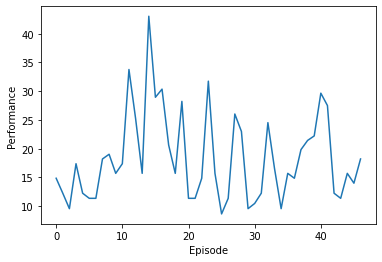

In [27]:
plt.plot(performances)
plt.xlabel("Episode")
plt.ylabel("Performance")

## EXERCISE 2: Score function

To compute the policy gradient, we just need to differentiate the log-action-probability. This gradient is called **score function**

$\Huge \nabla_\theta\log\pi_\theta(a|s)$

A stub of the `score_function` method is given.

**Hint 1:** if you haven't implemented the `log_policy` method yet, it is a good time to do it!

**Hint 2:** `log_policy` has an another argument than the policy parameters (the state). By default, `grad` differentiates w.r.t. the *first* function argument

**Hint 3:** `log_policy` returns a vector of probabilities, one for each action, but `grad` can only differentiate scalar-valued functions. You may want to index the probability vector *before* differentiating. JAX encourages a functional-programming style: use `lambda` or nested functions to define exactly what you want to differentiate

## EXERCISE 3: REINFORCE

Finally, we need to estimate the policy gradient from data. The simplest way is given by the REINFORCE estimator (here given in the "PGT" variant):

$\LARGE \widehat{\nabla}_\theta J(\theta)=\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(A_t\mid S_t)\sum_{h=t}^{T-1}\gamma^h R_{h+1}$

Implement the gradient ascent update in the `update` method using the REINFORCE gradient estimator and the `score_function` method you have implemented before.

You may need to play with the `learning_rate` parameter. A larger learning rate can lead to faster convergence but also to instabilities.

In [28]:
class PGSoftmaxAgent(SoftmaxAgent):
    """
    Agent learning a linear-Softmax policy with REINFORCE
    
    Attributes
    state_dim: dimension of state vector
    n_actions: number of available actions
    discount: discount factor of rewards
    learning_rate: learning rate of the gradient-ascent update (alpha)
    """
    def __init__(self, state_dim, n_actions, seed=0, discount=0.99, learning_rate=1e-3):
        super().__init__(state_dim, n_actions, seed)
        self.discount = discount
        self.learning_rate = learning_rate
        
    def reset(self, seed=0):
        super().reset(seed=seed)
        #bookkeeping:
        self.discounted_rewards = [] #will store discounted rewards for each timestep, just for current episode
        self.scores = [] #will store scores (grad-log-pi) for each timestep, just for current episode
    
    def update(self, state, action, discounted_reward, next_state, done):
        #bookkeeping:
        current_param = self.policy_parameters
        self.discounted_rewards.append(discounted_reward)
        score = self.score_function(current_param, state, action) #calls the method you have implemented in Ex. 2
        self.scores.append(score)
        
        if done:
            #At the end of each episode, update policy parameters with estimated policy gradient            
            #SOLUTION
            returns_to_go = jnp.cumsum(jnp.array(self.discounted_rewards)[::-1])[::-1]
            policy_gradient = jnp.dot(jnp.array(self.scores).T, returns_to_go).T
            new_param = current_param + self.learning_rate * policy_gradient
            self.policy_parameters = new_param
            self.discounted_rewards = []
            self.scores = []
            #END SOLUTION
            
            #bookkeping: data are discarded after each policy update
            self.discounted_rewards = []
            self.scores = []

Time to test you learning agent! You should see a small improvement w.r.t. the random policy

In [29]:
reinforce_agent = PGSoftmaxAgent(state_dim, n_actions, seed=0, learning_rate=1e-3)
performances = run_interaction(env, reinforce_agent, n_steps=10000, render=False)

Episode 1: performance = 25.28
Episode 2: performance = 8.65
Episode 3: performance = 12.25
Episode 4: performance = 13.99
Episode 5: performance = 32.43
Episode 6: performance = 10.47
Episode 7: performance = 19.84
Episode 8: performance = 29.66
Episode 9: performance = 25.28
Episode 10: performance = 8.65
Episode 11: performance = 21.43
Episode 12: performance = 24.53
Episode 13: performance = 23.00
Episode 14: performance = 23.77
Episode 15: performance = 21.43
Episode 16: performance = 33.10
Episode 17: performance = 17.38
Episode 18: performance = 16.55
Episode 19: performance = 22.22
Episode 20: performance = 17.38
Episode 21: performance = 26.03
Episode 22: performance = 14.85
Episode 23: performance = 17.38
Episode 24: performance = 17.38
Episode 25: performance = 19.84
Episode 26: performance = 33.77
Episode 27: performance = 14.85
Episode 28: performance = 26.03
Episode 29: performance = 22.22
Episode 30: performance = 17.38
Episode 31: performance = 19.84
Episode 32: perform

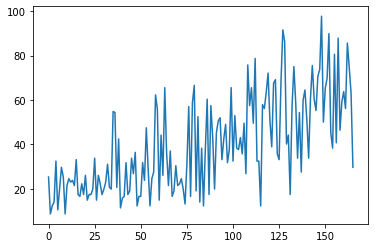

In [30]:
plt.plot(performances)

You should notice a slight increase in the performance...but what behavior has the agent actually learned? It is a good practice to render the behavior of the learned policy. You should compare it with the random policy that was defined at the beginning of the tutorial.

*Random policy:*

In [31]:
%%capture
env = gym.make("CartPole-v1") #create a new environment to avoid pygame display errors
run_interaction(env, random_agent, n_steps=200, render=True, seed=0); #display behavior of random policy

*Learned policy:*

In [32]:
%%capture
env = gym.make("CartPole-v1") #create a new environment to avoid pygame display errors
run_interaction(env, reinforce_agent, n_steps=500, render=True, seed=0); #display behavior of learned policy

## Extras

There are several ways you can improve your learning agent!

### Computational efficiency

* Jax offers many ways to speed up computations https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#using-jit-to-speed-up-functions
* The action sampling of the Softmax policy can be made more efficient using the Gumbel trick https://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/. The Gumbel distribution is already available in `jax.random` https://jax.readthedocs.io/en/latest/_autosummary/jax.random.gumbel.html

### Variance reduction
* Variance of the estimated gradients is one of the main drawbacks of policy gradient algorithms. A first way to reduce variance is to increase the **batch size**. You just need to collect $N>1$ trajectories for each policy update (e.g. $N=100$) and then average the $N$ gradient estimates. Here superscripts are used to index trajectories.
<br />
$\Large \widehat{\nabla}_\theta J(\theta)=\frac{1}{N}\sum_{i=1}^N\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(A_t^{(i)}\mid S_t^{(i)})\sum_{h=t}^{T-1}\gamma^h R_{h+1}^{(i)}$

* You can then add a **baseline** to your gradient estimator:<newline/>
    $\Large \widehat{\nabla}_\theta J(\theta)=\frac{1}{N}\sum_{i=1}^N\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(A_t^{(i)}\mid S_t^{(i)})\sum_{h=t}^{T-1}\left(\gamma^h R_{h+1}^{(i)} - b_h\right)$ 
<br />
Any baseline that does not depend on actions keeps the gradient estimator unbiased, and a good baseline can reduce variance. A common choice is the average-reward baseline 
<br />
$\Large b_h = \frac{1}{N}\sum_{i=1}^N\sum_{h=t}^{T-1}\gamma^h R_{h+1}^{(i)}$
<br />
See <a href="https://www.sciencedirect.com/science/article/pii/S0893608008000701">this paper</a> for more sophisticated variance-reduction baselines


* **Actor critic (advanced)**: instead of estimating the Q functions with the return-to-go, you can learn it using your favourite policy evaluation algorithm
<br />
$\Large \widehat{\nabla}_\theta J(\theta)=\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(A_t\mid S_t)\hat{Q}_\theta(S_t, A_t)$
<br />
Designing actor-critic algorithms is a subtle art. A general principle is that the critic (the approximated Q function) should be updated at a faster rate than the actor (the policy), e.g. by using a larger learning rate.
<a href="https://papers.nips.cc/paper/1999/hash/6449f44a102fde848669bdd9eb6b76fa-Abstract.html">Here</a> is a good reference 


### Policy class
* **State features**: The policy class we have considered so far may be too simple to achieve optimal performance. You may try to handcraft some state features $\phi:\mathcal{S}\to\mathbb{R}^d$ and use the following policy class
<br />
$\Large \pi_\theta(a\mid s) = \frac{\exp(\theta_a\cdot \phi(s))}{\sum_{a'\in\mathcal{A}}\exp(\theta_{a'}\cdot \phi(s))}$

* **Go deep! (advanced)** If you can't think of good features, you can try to implement a deep policy class where the exponential weights are given by a neural network that takes states as inputs, and the policy parameters are the weights of the network. Here is a possible partial implementation using `stax` (https://jax.readthedocs.io/en/latest/jax.example_libraries.stax.html)

In [33]:
from jax.example_libraries import stax

class DeepAgent(PGSoftmaxAgent):
    def __init__(self, state_dim, n_actions, hidden=8):
        #neural network with one hidden layer
        self.nn_init, self.model = stax.serial(
            stax.Dense(hidden), #state as input
            stax.Tanh, #tanh activations
            stax.Dense(n_actions)) #one output per action (the unnormalized log-probabilities)
        super().__init__(state_dim, n_actions)
        
    def reset(self, seed=0):
        key = random.PRNGKey(seed)
        output_shape, params_init = self.nn_init(key, (-1, self.state_dim)) #initialization of network weights
        self.param = params_init #policy parameters are network weights
    
    def log_policy(self, policy_parameters, state):
        x = jnp.array(state)
        unn_log_probs = self.model(policy_parameters, x) #the network gives the unnormalized log probabilities
        #...